# Step 1: Load Data & Initial Exploration

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



In [66]:
# Load dataset
df = pd.read_csv("heart_attack_risk_dataset.csv")

df.head()

,Age,Gender,Smoking,Alcohol_Consumption,Physical_Activity_Level,BMI,Diabetes,Hypertension,Cholesterol_Level,Resting_BP,Heart_Rate,Family_History,Stress_Level,Chest_Pain_Type,Thalassemia,Fasting_Blood_Sugar,ECG_Results,Exercise_Induced_Angina,Max_Heart_Rate_Achieved,Heart_Attack_Risk
0,69,Female,1,0,Moderate,34.61,1,0,152.1,171,85,0,Moderate,Non-anginal,Reversible defect,0,Normal,0,114,Low
1,32,Male,0,0,Moderate,22.75,0,0,166.8,126,103,0,Low,Asymptomatic,Normal,0,ST-T abnormality,0,173,Moderate
2,89,Male,0,1,Moderate,35.32,0,0,272.3,123,127,0,Low,Typical,Reversible defect,0,ST-T abnormality,0,109,Low
3,78,Male,0,1,Moderate,18.23,1,0,237.7,144,125,0,Low,Typical,Fixed defect,1,Left Ventricular Hypertrophy,0,129,Low
4,38,Female,1,0,Moderate,19.82,0,0,207.7,123,107,0,High,Asymptomatic,Reversible defect,0,ST-T abnormality,0,124,Moderate


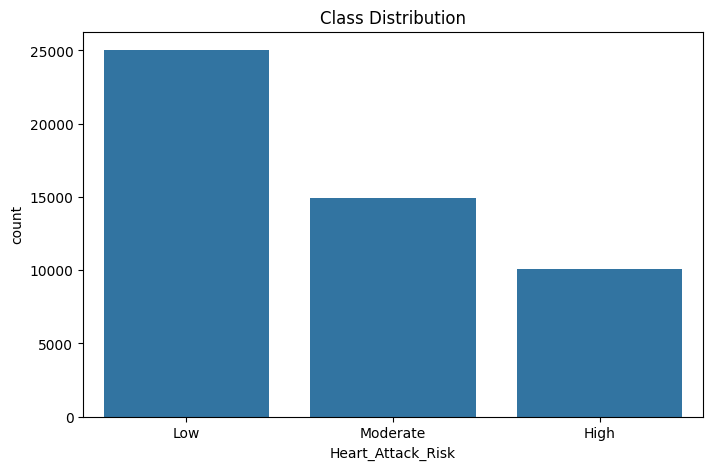

In [67]:
# Display class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Heart_Attack_Risk', data=df)
plt.title("Class Distribution")
plt.show()

# Step 2: Data Preprocessing


In [68]:
# --- Step 1: Encode TARGET variable ---
le = LabelEncoder()
df["Heart_Attack_Risk"] = le.fit_transform(df["Heart_Attack_Risk"])  # 0=Low, 1=Moderate, 2=High

# --- Step 2: Separate features and labels ---
X = df.drop("Heart_Attack_Risk", axis=1)
y = df["Heart_Attack_Risk"]

# --- Step 3: Encode FEATURES ---
# Identify all categorical columns in features (X)
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns in features:", categorical_cols)

# One-hot encode categorical features
if categorical_cols:
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# --- Step 4: Normalize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 5: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Categorical columns in features: ['Gender', 'Physical_Activity_Level', 'Stress_Level', 'Chest_Pain_Type', 'Thalassemia', 'ECG_Results']


# Step 3: Data Visualization

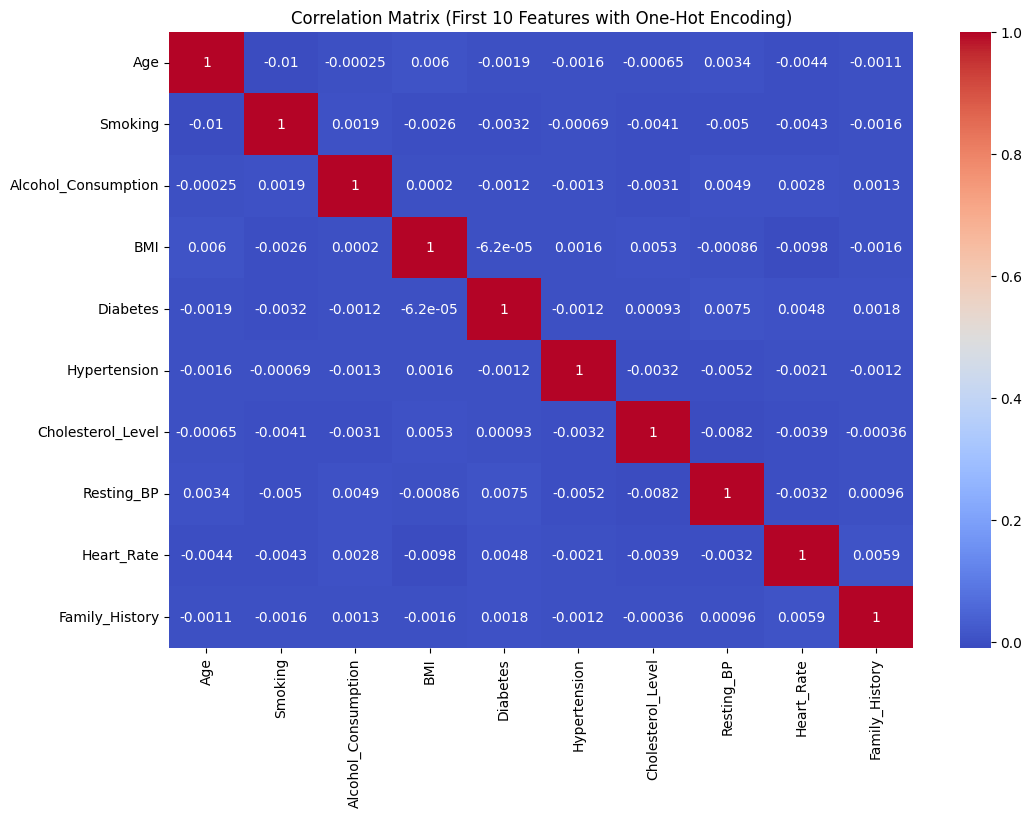

In [70]:
# Perform one-hot encoding on categorical columns
df_encoded = pd.get_dummies(df, drop_first=True)

# Plot the correlation matrix for the first 10 columns
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.iloc[:, :10].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix (First 10 Features with One-Hot Encoding)")
plt.show()

# Step 4: Create PyTorch Dataset & DataLoader


In [48]:
class HeartAttackDataset(Dataset):
    def __init__(self, features, labels):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(labels.values if isinstance(labels, pd.Series) else labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = HeartAttackDataset(X_train, y_train)
test_dataset = HeartAttackDataset(X_test, y_test)

# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Step 5: Define the Model


In [63]:
class HeartAttackNN(torch.nn.Module):
    def __init__(self, input_dim):
        super(HeartAttackNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 3)  # 3 output classes
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation for raw logits
        return x

# Initialize model
input_dim = X_train.shape[1]
model = HeartAttackNN(input_dim)
print(model)

HeartAttackNN(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)


# Step 6: Training & Evaluation


Epoch 1/50, Loss: 1.0394
Epoch 2/50, Loss: 1.0337
Epoch 3/50, Loss: 1.0329
Epoch 4/50, Loss: 1.0314
Epoch 5/50, Loss: 1.0312
Epoch 6/50, Loss: 1.0300
Epoch 7/50, Loss: 1.0292
Epoch 8/50, Loss: 1.0294
Epoch 9/50, Loss: 1.0280
Epoch 10/50, Loss: 1.0274
Epoch 11/50, Loss: 1.0278
Epoch 12/50, Loss: 1.0264
Epoch 13/50, Loss: 1.0249
Epoch 14/50, Loss: 1.0250
Epoch 15/50, Loss: 1.0238
Epoch 16/50, Loss: 1.0238
Epoch 17/50, Loss: 1.0226
Epoch 18/50, Loss: 1.0216
Epoch 19/50, Loss: 1.0216
Epoch 20/50, Loss: 1.0197
Epoch 21/50, Loss: 1.0208
Epoch 22/50, Loss: 1.0195
Epoch 23/50, Loss: 1.0191
Epoch 24/50, Loss: 1.0196
Epoch 25/50, Loss: 1.0181
Epoch 26/50, Loss: 1.0183
Epoch 27/50, Loss: 1.0180
Epoch 28/50, Loss: 1.0169
Epoch 29/50, Loss: 1.0161
Epoch 30/50, Loss: 1.0152
Epoch 31/50, Loss: 1.0150
Epoch 32/50, Loss: 1.0145
Epoch 33/50, Loss: 1.0128
Epoch 34/50, Loss: 1.0134
Epoch 35/50, Loss: 1.0134
Epoch 36/50, Loss: 1.0134
Epoch 37/50, Loss: 1.0129
Epoch 38/50, Loss: 1.0121
Epoch 39/50, Loss: 1.

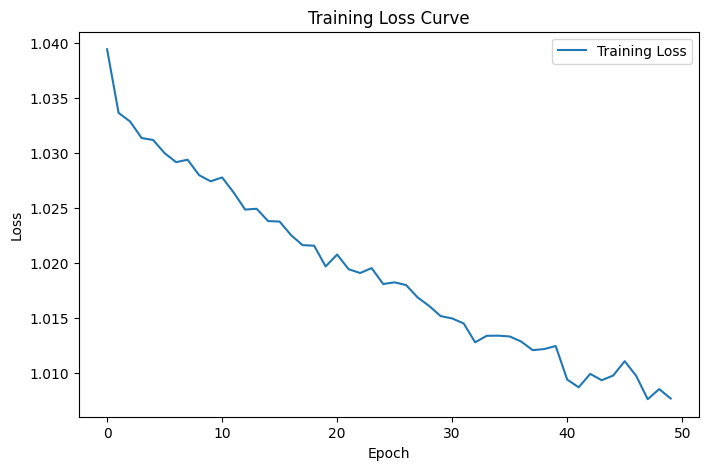

In [64]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Curve")
plt.show()

# Step 7: Test & Predictions


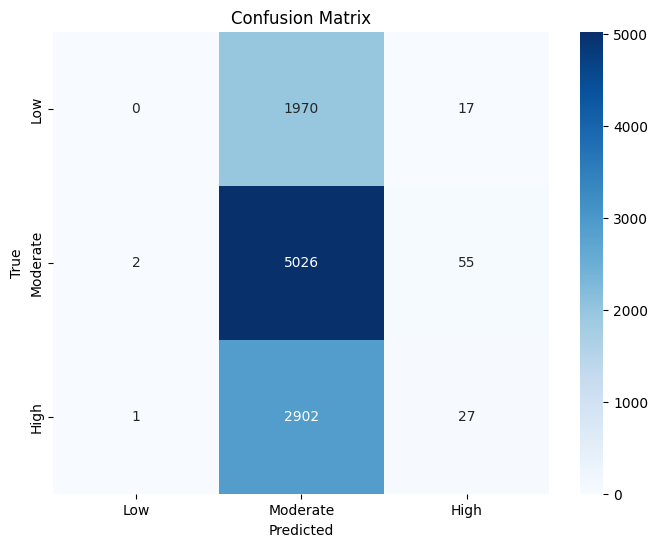

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00      1987
    Moderate       0.51      0.99      0.67      5083
        High       0.27      0.01      0.02      2930

    accuracy                           0.51     10000
   macro avg       0.26      0.33      0.23     10000
weighted avg       0.34      0.51      0.35     10000



In [51]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Moderate", "High"],
            yticklabels=["Low", "Moderate", "High"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=["Low", "Moderate", "High"]))